In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from quantum_tools.examples.symbolic_contexts import *
from quantum_tools.symmetries.workspace import *
from quantum_tools.visualization.sparse_vis import plot_coo_matrix
from quantum_tools.config import *
from scipy import sparse
import numpy as np

In [3]:
ABC_222_222

SymbolicContext(preinjectable_sets=[[['A2'], ['B2'], ['C2']], [['B2'], ['A2', 'C1']], [['C2'], ['A1', 'B2']], [['A2'], ['B1', 'C2']], [['A1', 'B1', 'C1']]], outcomes=[2, 2, 2, 2, 2, 2])

In [4]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(ABC_222_222)

40 64
ShiftedBase(shift=0, base=(32, 16, 8, 4, 2, 1))
ShiftedBase(shift=0, base=(0, 4, 0, 2, 0, 1))
ShiftedBase(shift=8, base=(0, 4, 0, 2, 1, 0))
ShiftedBase(shift=16, base=(4, 0, 0, 2, 0, 1))
ShiftedBase(shift=24, base=(0, 4, 2, 0, 0, 1))
ShiftedBase(shift=32, base=(4, 0, 2, 0, 1, 0))
Found 14 row_orbits.
Found 20 col_orbits.


In [5]:
A

<40x64 sparse matrix of type '<class 'numpy.float64'>'
	with 320 stored elements in COOrdinate format>

<IPython.core.display.Javascript object>


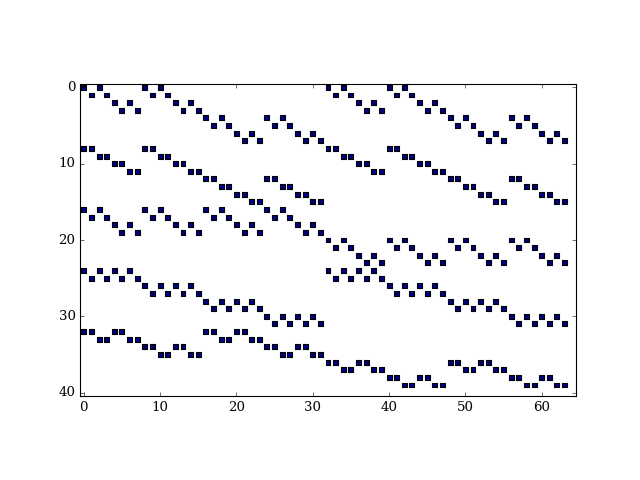

In [6]:
plot_coo_matrix(A)

<IPython.core.display.Javascript object>


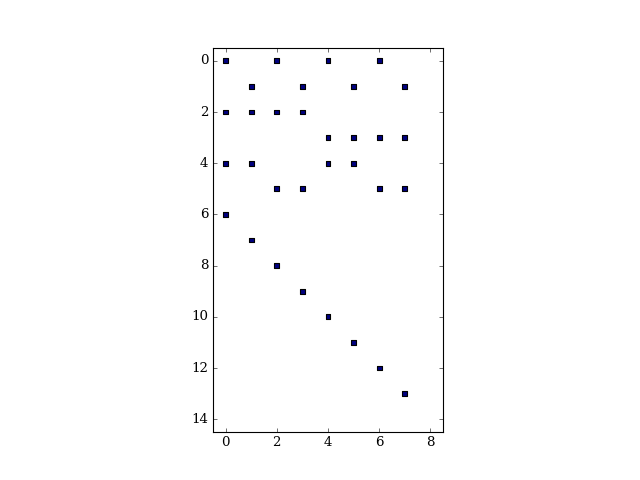

In [10]:
H = hyper_graph(A, 0)
plot_coo_matrix(H)

In [12]:
H_bool = H.astype(bool)
# x = sparse.csr_matrix(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0]), dtype=bool)
# H.bitwise_or(x)

<IPython.core.display.Javascript object>


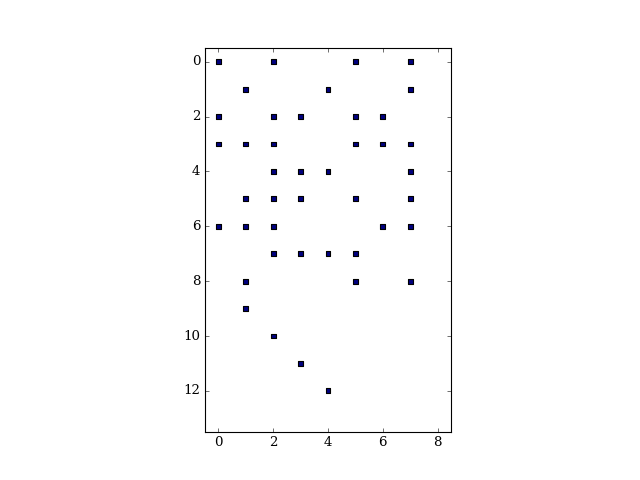

In [6]:
mediumH = sparse.csr_matrix(np.array([
            [1, 0, 1, 0, 0, 1, 0, 1],
            [0, 1, 0, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 0, 0, 1, 1, 1],
            [0, 0, 1, 1, 1, 0, 0, 1],
            [0, 1, 1, 1, 0, 1, 0, 1],
            [1, 1, 1, 0, 0, 0, 1, 1],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 1],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
        ]))
smallH = sparse.csr_matrix(np.array([
            [1, 0, 1, 0, 1],
            [0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0],
            [1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ]))
xsmallH = sparse.csr_matrix(np.array([
            [1, 0, 1],
            [0, 1, 1],
            [1, 1, 0],
        ]))
plot_coo_matrix(mediumH)

In [7]:
from functools import reduce
from operator import mul

def nzcfr(M, row):
    """ Non zero columns for a given row of a csr matrix """
    return M.indices[M.indptr[row]:M.indptr[row+1]]

def ptrflux(indptr):
    flux = indptr[1:] - indptr[:-1]
    return np.nonzero(flux)[0]

def sparse_any_eq(A, B):
    """
    SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
    """
    # If anything in the sparse diff is false, then some of A and B are equal
    sparse_diff = A != B
    diff_len = reduce(mul, sparse_diff.shape, 1)
    
    if sparse_diff.nnz == diff_len:
        return False
    else:
        return True

def hyper_graph(A, ant):
    A_coo = sparse.coo_matrix(A)
    A_csr = sparse.csr_matrix(A)
    # A_csc = sparse.csc_matrix(A)
    # Take only columns that are extendable versions of the antescedant (ant)
    ext_ant = nzcfr(A_csr, ant)
    ext_A = A_csr[:, ext_ant]
    # Take only rows that would contribute
    row_entry_flux = ext_A.indptr[1:] - ext_A.indptr[:-1] # Finds where the row pointers change
    row_entry_flux[ant] = 0 # Make antecedant zero so it doesn't get selected
    H = ext_A[np.nonzero(row_entry_flux)[0], :]
    return H

In [120]:
def min_col(v):
    min_val = np.inf
    min_i = None
    for i in range(v.shape[0]):
        v_i = v.data[v.indptr[i]:v.indptr[i+1]]
        if len(v_i) == 0: # No entries
            val_v_i = 0
        else:
            val_v_i = v_i[0]
        if val_v_i < min_val:
            min_val = val_v_i
            min_i = i
    return min_i, min_val

def max_col(v):
    max_val = -np.inf
    max_i = None
    for i in range(v.shape[0]):
        v_i = v.data[v.indptr[i]:v.indptr[i+1]]
        if len(v_i) == 0: # No entries
            val_v_i = 0
        else:
            val_v_i = v_i[0]
        if val_v_i > max_val:
            max_val = val_v_i
            max_i = i
    return max_i, max_val

In [230]:
# def compressed_sparse_stack(blocks, axis):
#     """
#     Stacking fast path for CSR/CSC matrices
#     (i) vstack for CSR, (ii) hstack for CSC.
#     """
#     print('blocks')
#     print(blocks)
#     other_axis = 1 if axis == 0 else 0
#     data = np.concatenate([b.data for b in blocks])
#     indices = np.concatenate([b.indices for b in blocks])
#     indptr = []
#     last_indptr = 0
#     constant_dim = blocks[0].shape[other_axis]
#     sum_dim = 0
#     print(constant_dim)
#     for b in blocks:
#         print(b.toarray())
#         print(b.shape[other_axis])
#         if b.shape[other_axis] != constant_dim:
#             raise ValueError('incompatible dimensions for axis %d' % other_axis)
#         sum_dim += b.shape[axis]
#         indptr.append(b.indptr[:-1] + last_indptr)
#         last_indptr += b.indptr[-1]
#     indptr.append([last_indptr])
#     indptr = np.concatenate(indptr)
#     if axis == 0:
#         return sparse.csr_matrix((data, indices, indptr), shape=(sum_dim, constant_dim))
#     else:
#         return sparse.csc_matrix((data, indices, indptr), shape=(constant_dim, sum_dim))
    
# def sparse_hstack(blocks):
#     return compressed_sparse_stack(blocks, 1)

# def sparse_vstack(blocks):
#     return compressed_sparse_stack(blocks, 0)

In [8]:
import inspect

class VerboseLog():
    
    def __init__(self, on=False):
        self.on = on
        
    def log(self, *args):
        if self.on:
            curframe = inspect.currentframe()
            calframe = inspect.getouterframes(curframe, 2)
            caller_name = calframe[1][3]
            print('[{name}]:'.format(name=caller_name), *args)

In [31]:
class FoundTransversals():
    
    def __init__(self):
        self.__data = None
        
    def __len__(self):
        if self.__data is None:
            return 0
        else:
            return self.__data.shape[1]
        
    def update(self, ft):
        ft = sparse.csc_matrix(ft)
        if self.__data is None:
            self.__data = sparse.csc_matrix(ft) # start it off
        else:
            fts = self.__data
            overlap = ft.T.dot(fts).toarray()
            total_ft = sparse.spmatrix.sum(ft)
            fts_to_keep = np.ones(len(self), dtype=bool) # Keep all to start
            for i in range(len(self)):
                ft_i_data = fts.data[fts.indptr[i]:fts.indptr[i+1]] # ndarray of nodes in the transversal
                total_i = np.sum(ft_i_data)
                if overlap[0,i] == total_i: # ft_i is more minimal than ft
                    return # Do nothing
                # overlap[0,i] < total_i
                elif overlap[0,i] == total_ft: # ft is more minimal than ft_i
#                     pass
                    fts_to_keep[i] = False # delete it
                else:
                    continue
            if not np.any(fts_to_keep):
                self.__data = sparse.csc_matrix(ft)
            elif np.all(fts_to_keep):
                self.__data = sparse.hstack((self.__data, ft))    
            else:
                self.__data = sparse.hstack((self.__data[:, fts_to_keep], ft))
            
    def minimal_present(self, ft):
        if self.__data is None:
            return False
        else:
            return is_minimal_present(ft, self.__data)
            
    def __getitem__(self, slice):
        if self.__data is None:
            return None
        return self.__data[slice]
    
    def data(self):
        return self.__data
    
    def has_data(self):
        return self.__data is not None
    
def is_minimal_present(t, ts):
    """ Determines if a more mimimal transversal than t is present in ts """
    if ts is None:
        return False
    overlap = t.T * ts # How much t overlaps with the elements of ts
    total_fs = get_full_transversal(t.shape[0]).T * ts # Sums over the columns
    any_minimal = sparse_any_eq(overlap, total_fs)
    return any_minimal

def cernikov_filter(wts, fts=None):
    """ Remove any of the working transversals that are minimal versions of each other """
    wt_i = 0
    wts = sparse.csc_matrix(wts)
    vl.log('Filtering {0}...'.format(wts.shape[1]))
    if fts is not None:
        fts = sparse.csc_matrix(fts)
    
    while wt_i < wts.shape[1]:
        target_t = wts[:, wt_i]
        left_t = wts[:, :max(wt_i, 0)]
        right_t = wts[:, min(wt_i+1, wts.shape[1]):]
        
        assert(left_t.shape[1] + right_t.shape[1] + target_t.shape[1] == wts.shape[1]), "Left/Right split failed."
        
        left_right_t = sparse.hstack((left_t, right_t))
        if fts is not None:
            check_ts = sparse.hstack((left_right_t, fts))
        else:
            check_ts = left_right_t
        
        if is_minimal_present(target_t, check_ts):
            wts = left_right_t # The new wts to loop over
            # [logic] wt_i = wt_i # Don't increase
        else:
            # [logic] wts = wts # Keep target
            wt_i += 1
    vl.log('...down to {0}'.format(wts.shape[1]))
    return wts
            
class SearchStrat():
    pass
    
    depth   = 'depth'
    breadth = 'breadth'
        
def get_null_transveral(size):
    """
    size : number of nodes
    """
    return sparse.csc_matrix((size, 1), dtype='int32')

_full_transversal_pool = {}
def get_full_transversal(size):
    """
    size : number of nodes
    """
    global _full_transversal_pool
    if size not in _full_transversal_pool:
        _full_transversal_pool[size] = sparse.csc_matrix(np.ones((size, 1)), dtype='int32')
    return _full_transversal_pool[size]

_unit_completion_pool = {}
def get_unit_completion(size):
    """
    size : number of edges
    """
    global _unit_completion_pool
    if size not in _unit_completion_pool:
        _unit_completion_pool[size] = sparse.csr_matrix(np.ones(size), dtype='int32')
    return _unit_completion_pool[size]
        
def find_transversals(H, strat=SearchStrat.depth):
    H = sparse.csc_matrix(H) # Needed for the algorithm
    fts = FoundTransversals() # Empty found transversals
    num_nodes = H.shape[0]
    if strat == SearchStrat.depth:
        work_on_transversals_depth(H, get_null_transveral(num_nodes), fts)
    else:
        work_on_transversals_breadth(H, get_null_transveral(num_nodes), fts)
    return fts.data()

def verify_completion(H, wt, fts):
    # Check if transversal is complete
    completion = transversal_completion(H, wt)
    vl.log('completion')
    vl.log(completion)
    vl.log('is_completion')
    vl.log(is_complete_transversal(completion))
    if is_complete_transversal(completion):
        fts.update(wt) # Update the list of transversals with the new found one
        return True, None
    return False, completion

def work_on_transversals_breadth(H, wts, fts, current_depth=0):
    """ Work on a particular transversal going breadth first """
    # Current depth
    vl.log('current_depth')
    vl.log(current_depth)
    
    # Nothing to work on
    if wts is None or wts.shape[1] == 0:
        vl.log('Finished: Nothing to branch to.')
        return
    
    next_wts_list = []
    for wt_i in range(wts.shape[1]):
        wt = wts[:, wt_i]
        # Check if transversal is complete
        is_complete, completion = verify_completion(H, wt, fts)
        if is_complete:
            fts.update(wt)
            continue
    
        # Otherwise, branch to nodes that can contribute
        for node in branch_to_nodes(H, wt, completion):
            next_wt = continue_transveral(H, wt, node)
            next_wts_list.append(next_wt)
    
    # Nothing valid to continue on
    if len(next_wts_list) == 0:
        vl.log('Finished: All branches complete.')
        return
    
    next_wts_mtrx = sparse.hstack(next_wts_list)
    
    # Filter out minimal copies
    next_wts = cernikov_filter(next_wts_mtrx, fts.data()) # Will iterate over columns
    
    work_on_transversals_breadth(H, next_wts, fts, current_depth + 1)        

def work_on_transversals_depth(H, wt, fts, current_depth=0):
    """ Work on a particular transversal going depth first """
    # Current depth
    vl.log('current_depth')
    vl.log(current_depth)

    # Check if transversal is complete
    is_complete, completion = verify_completion(H, wt, fts)
    if is_complete:
        return
    
    # Otherwise, branch to nodes that can contribute
    for node in branch_to_nodes(H, wt, completion):
        next_wt = continue_transveral(H, wt, node)
        if fts.minimal_present(next_wt):
            # A more minimal transversal is present, just continue on
            continue
        work_on_transversals_depth(H, next_wt, fts, current_depth + 1)        
        
def is_complete_transversal(completion):
    """ Given a completion is it complete """
    # Completion is a row vector
    return completion.nnz == completion.shape[1] # No nonzero elements means completion
    
def transversal_completion(H, t):
    """ Tells me the edges that were hit already (and how many times) """
    return t.T.dot(H)

def transversal_overlap(H, t):
    """ Get the overlap between the edges of a transversal (completion) and the entire hypergraph """
    return H.dot(t.T)

def continue_transveral(H, wt, node):
    """
    H : hypergraph
    wt : working transversal
    node : node to be chosen 
    """
    new_indices = np.append(wt.indices, [node])
    new_indptr = np.copy(wt.indptr)
    new_indptr[1] = len(new_indices)
    new_data = np.append(wt.data , [1])
    
    wt_new = sparse.csc_matrix((new_data, new_indices, new_indptr), shape=wt.shape)
    
    vl.log('new_t')
    vl.log(wt_new)
    
    return wt_new
    
def get_missing_edges(H, wt, completion):
    completion.data = np.ones(len(completion.data)) # unitize
    missing_edges = get_unit_completion(H.shape[1]) - completion # find what edges are missing
    return missing_edges
    
def branch_to_edges(H, wt, completion):
    missing_edges = get_missing_edges(H, wt, completion) # Obtain the missing edge sparse list
    edges = missing_edges.indices
    if len(edges) != 0:
        yield edges[0] # Even if it's not sorted, take a missing edge

# def edge_vector(edge, size):
#     return sparse.csr_matrix((np.ones(1), np.array([edge]), np.array([0, 1])),  shape=(1, size))
        
def branch_to_nodes(H, wt, completion):
    """
    decide which nodes to branch to next
    """
    next_edges = branch_to_edges(H, wt, completion)
    H = sparse.csc_matrix(H) # Ensures the matrix is csc format (should already be)
    for edge in next_edges:
        node_indices_to_contribute = H[:, edge].indices
#         edge_v = edge_vector(edge, H.shape[1])
#         nodes_to_contribute = transversal_overlap(H, edge_v)
#         node_indices_to_contribute = ptrflux(nodes_to_contribute.indptr)
        for i in node_indices_to_contribute:
            if not wt[i, 0] > 0: # not already part of working transversal
                vl.log('Branching to node')
                vl.log(i)
                yield i


In [32]:
vl = VerboseLog(False)

In [36]:
find_transversals(hyper_graph(A, 0), strat=SearchStrat.depth).toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0,

In [ ]:
H_0

In [138]:
H_0.shape

(14, 30)

In [40]:
vl = VerboseLog(False)
PROFILE_MIXIN(find_transversals, hyper_graph(A, 11), 'depth')

         1501707 function calls (1498357 primitive calls) in 2.258 seconds

   Ordered by: internal time
   List reduced from 158 to 32 due to restriction <0.2>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17865    0.291    0.000    0.780    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/compressed.py:126(check_format)
    41257    0.194    0.000    0.436    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/sputils.py:125(get_index_dtype)
   227500    0.163    0.000    0.163    0.000 {built-in method array}
   181598    0.131    0.000    0.247    0.000 /usr/lib/python3.4/site-packages/numpy/core/numeric.py:414(asarray)
17865/15063    0.130    0.000    1.416    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/compressed.py:24(__init__)
    41599    0.110    0.000    0.110    0.000 /usr/lib/python3.4/site-packages/numpy/core/getlimits.py:245(__init__)
    17865    0.098    0.000    0.169    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/comp

In [130]:
ft.shape

NameError: name 'ft' is not defined

In [54]:
# Testing algorithm elements
wt = get_null_transveral(H)
wt = continue_transveral(H, wt, 5)
wt = continue_transveral(H, wt, 10)
wt = continue_transveral(H, wt, 11)
wt = continue_transveral(H, wt, 6)
wt = continue_transveral(H, wt, 7)
print('wt')
print(wt)
completion = transversal_completion(H, wt)
# print(is_complete_transversal(completion))
print('completion')
print(completion)
overlap = transversal_overlap(H, completion)
print('is_complete')
print(is_complete_transversal(completion))
print('overlap')
print(overlap)
print('branch_to_nodes')
print(list(branch_to_nodes(overlap)))

wt
  (5, 0)	1
  (6, 0)	1
  (7, 0)	1
  (10, 0)	1
  (11, 0)	1
completion
  (0, 5)	1.0
  (0, 4)	1.0
  (0, 1)	1.0
  (0, 0)	1.0
  (0, 7)	1.0
  (0, 6)	1.0
  (0, 3)	1.0
  (0, 2)	1.0
is_complete
True
overlap
  (0, 0)	4.0
  (1, 0)	4.0
  (2, 0)	4.0
  (3, 0)	4.0
  (4, 0)	4.0
  (5, 0)	4.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
branch_to_nodes
[]


In [156]:
t, completion, overlap = branch_transveral(H, get_null_transveral(H), 0)

  (0, 0)	True
  (0, 6)	1.0
  (0, 4)	1.0
  (0, 2)	1.0
  (0, 0)	1.0
  (0, 0)	4.0
  (2, 0)	2.0
  (3, 0)	2.0
  (4, 0)	2.0
  (5, 0)	2.0
  (6, 0)	1.0
  (8, 0)	1.0
  (10, 0)	1.0
  (12, 0)	1.0


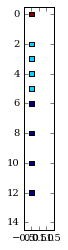

In [158]:
plot_coo_matrix(overlap)

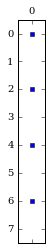

  (0, 0)	1.0
  (2, 0)	1.0
  (4, 0)	1.0
  (6, 0)	1.0


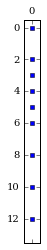

In [89]:
plot_coo_matrix(H[0].T)

x = H[0].T
print(x)

plot_coo_matrix(H.dot(x))

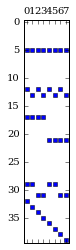